In [ ]:
!pip install -q lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.8 MB/s eta 0:00:00


In [ ]:
!pip uninstall -q wandb -y

# Семинар 5. Self-supervised learning. Large language models

В этом семинаре мы рассмотрим SSL в задачах NLP и CV. Мы будем использовать библиотеку transformers, а также познакомимся с фреймворком Pytorch Lightning. Также посмотрим на LLM

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torchmetrics
from sklearn.model_selection import train_test_split

RANDOM_STATE = 777

## BERT + Transformers

Рассмотрим BERT для задачи классификации [текста](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv). Для этого будем использовать библиотеку [transformers](https://huggingface.co/docs/transformers/index), в которой собраны множество инструментов для решения NLP задач. Можно также удобно подгружать веса необходимых моделей и выгружать их на сервер, если заведете аккаунт на их сайте.

In [ ]:
df = pd.read_csv("train.csv")
texts = df["text"].tolist()
labels = df["target"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_STATE
)

Заведем функцию для токенизации текстов. Всю тяжелую работу за нас делает *достаточно* дружелюбная библиотека, нам стоит лишь подгрузить BERT-токенизатор, изучить [параметры](https://huggingface.co/docs/transformers/v4.46.2/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__) и voila.

In [ ]:
def tokenize_function(texts, tokenizer):
    return tokenizer(
        texts,
        # return_tensors="pt",  # этот параметр отвечает за возвращение данных в виде torch.tensor
                                # для прозрачности и целостности было решено оставить приведение к тензору ниже
        padding="max_length",   # используемая стратегия паддинга
        truncation=True,        # будем ли мы отсекать лишнее от слишком длинных последовательностей
        max_length=128,         # размер последовательности
        )


In [ ]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenize_function(texts, tokenizer)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # в таком виде BERT for classification ожидает данные
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx]),
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = DisasterTweetsDataset(train_texts, train_labels, tokenizer)
val_dataset = DisasterTweetsDataset(val_texts, val_labels, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Для подсчета метрик очень удобно использовать библиотеку torchmetrics. В ней уже реализованы большое количество метрик, в том числе есть некоторые сегментационные.

In [ ]:
accuracy_metric = torchmetrics.Accuracy(num_classes=2, task='binary')
f1_metric = torchmetrics.F1Score(num_classes=2, task='binary')

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = accuracy_metric(predictions, torch.tensor(labels))
    f1 = f1_metric(predictions, torch.tensor(labels))
    return {"accuracy": accuracy.item(), "f1": f1.item()}

Теперь обучим BERT для задачи классификации текстов. Подгрузим веса, определим [параметры](https://huggingface.co/docs/transformers/v4.46.2/en/model_doc/bert#transformers.BertForSequenceClassification)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Определим [параметры](https://huggingface.co/docs/transformers/v4.46.2/en/main_classes/trainer#transformers.TrainingArguments) обучения. Их бесчисленное множество, и каждый позволяет тонко настроить процесс обучеения.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    bf16=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


И, наконец, начнем обучение.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-13-e42f33b5b1fc>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.384600,0.400282,0.831911,0.797468
2,0.259600,0.492400,0.819435,0.796748
3,0.202000,0.550874,0.822718,0.797904


TrainOutput(global_step=1143, training_loss=0.32401896706820577, metrics={'train_runtime': 443.9665, 'train_samples_per_second': 41.152, 'train_steps_per_second': 2.575, 'total_flos': 1201759745356800.0, 'train_loss': 0.32401896706820577, 'epoch': 3.0})

Посмотрим на результаты.

In [ ]:
eval_results = trainer.evaluate()

print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.5508739948272705, 'eval_accuracy': 0.8227183222770691, 'eval_f1': 0.7979041934013367, 'eval_runtime': 10.8793, 'eval_samples_per_second': 139.991, 'eval_steps_per_second': 8.824, 'epoch': 3.0}


## ViTMAE + Lightning

Познакомимся с [Lightning](https://pytorch-lighting.readthedocs.io/en/latest/)

**!!!! ОЧЕНЬ ВАЖНОЕ ЗАМЕЧАНИЕ !!!!**

ЗАПОМНИТЕ ЕГО В ЛИЦО И ВНИМАТЕЛЬНО СМОТРИТЕ НА ВАШИ ИМПОРТЫ!!!!

```python
import numpy as np
...
import pytorch_lightning as pl  # <-- ВОТ ОН!! МНОГО ОШИБКА ИМПОРТ ДЕЛАТЬ БОБО ВАША МЕНТАЛКА
...
```

ВАШ БРО - `lightning.pytorch`. НЕ ПУТАЙТЕ ЕГО НИ С КЕМ!!!!

В этой части рассмотрим SSL для изображений. Обучим ViTMAE для датасета CIFAR10. Для этого будем использовать Lightning.

In [16]:
# ради связности пусть импорты будут вынесены сюда
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from torchvision import  transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from transformers import ViTMAEModel, ViTMAEForPreTraining, AutoImageProcessor
from torchmetrics import MeanSquaredError, Accuracy

Определим класс для датасета CIFAR10. Pytorch Lightning, как ни странно, совместим с классами из обычного torch.

В датасете будем использовать предобработку изображений из библиотеки transforms. Удобно, что для каждой модели можно попробовать подтянуть специфичную для них предобработку и не реализовывать ее вручную.

In [ ]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.dataset = CIFAR10(
            root="./data",
            train=train,
            download=True,
        )
        self.processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), label

В Lighting есть свои аналоги модулкй из torch. Например, `pl.LightningDataModule` является оберткой для Dataset и Dataloader. В этом классе можно сразу определить логику подгрузки датасета с диска и обернуть в даталоадеры, которые будет потом использовать тренировщик.

Самое важное - функция setup. В ней определяется, как именно инициализируется датасет. Например, в этот класс можно завернуть загрузку датасета с облака, разделение его на трейн/вал/тест, обертку в датасет, подгрузку даталоадеров.

In [ ]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, num_workers=4):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

    # def prepare_data(self):

    def setup(self, stage=None):
        self.train_dataset = CIFAR10Dataset(train=True)
        self.val_dataset = CIFAR10Dataset(train=False)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

Своеобразным аналогом nn.Module является pl.LightningModule. В этом модуле определяются модель, логика обучения, подсчет метрик и прочее. Стандартных методов у модуля великое множество, буквально на каждый шаг обучения вы можете делать что-то свое.

In [ ]:
class ViTMAEModelWrapper(nn.Module):
    def __init__(self, mask_ratio, num_classes):
        super().__init__()
        self.model = ViTMAEModel.from_pretrained("facebook/vit-mae-base", mask_ratio=mask_ratio)
        self.classification_head = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.model(pixel_values=x, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]

        pooled_features = hidden_states.mean(dim=1)
        logits = self.classification_head(pooled_features)
        return logits

In [ ]:
class ViTMAELightningModule(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.75, num_classes=10, patch_size=16, image_size=(32, 32)):
        super().__init__()
        self.save_hyperparameters()

        self.model = ViTMAEModelWrapper(mask_ratio, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc(logits, labels), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        val_loss = self.criterion(logits, labels)

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.val_acc(logits, labels), prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


Lightning как библиотека делает за вас самое трудное в жизни ML-инженера - написание цикла обучения из раза в раз. При использовании библиотеки вам достаточно буквально настроить всю инфраструктуру обучения и запустить его. Не придется копировать один и тот же код для разных проектов, зачем, когда есть lightning?

In [ ]:
data_module = CIFAR10DataModule(batch_size=32, num_workers=4)

model = ViTMAELightningModule(lr=1e-4)

trainer = pl.Trainer(
    max_epochs=2,
    accelerator="cuda",
    devices=1,
    log_every_n_steps=10,
    precision=16,  # Используем mixed precision для ускорения
)

trainer.fit(model, data_module)

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170M/170M [00:05<00:00, 29.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Files already downloaded and verified


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ViTMAEModelWrapper | 85.8 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
85.7 M    Trainable params
151 K     Non-trainable params
85.8 M    Total params
343.225   Total estimated model params size (MB)
5         Modules in train mode
223       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Посмотрим, как ViTMAE умеет восстанавливать пропуски.

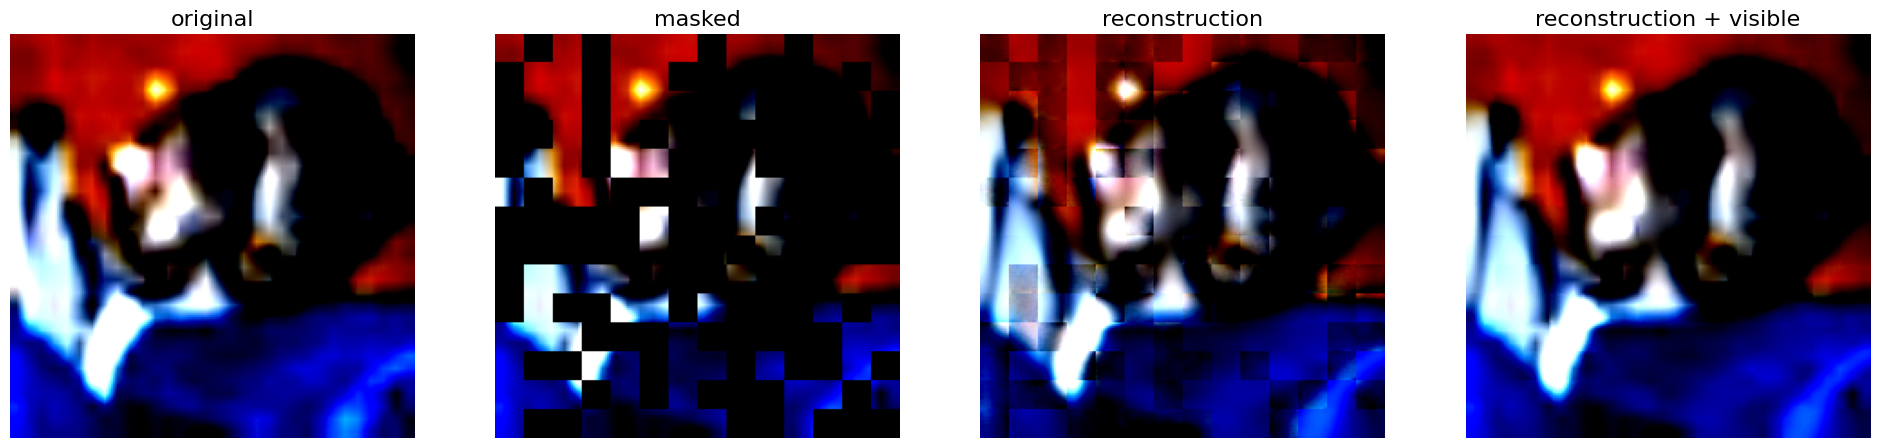

In [24]:
imagenet_std = np.array([0.229, 0.224, 0.225])
imagenet_mean = np.array([0.485, 0.456, 0.406])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

vitmae = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base", mask_ratio=0.5)
visualize(next(iter(data_module.val_dataloader()))[0], vitmae)

## LLM

Посмотрим, какие компактные модели можно запустить локально.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
inputs = tokenizer.encode("Gravity is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

tokenizer_config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Gravity is a force that pulls objects towards the center of the Earth. It is what makes things
